In [1]:
# So we can load files from other sub-directories, e.g. datasets.
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

In [79]:
import torch
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
from robustness.tools.breeds_helpers import make_living17, make_entity13, make_entity30, make_nonliving26

BREEDS_SPLITS_TO_FUNC = {
    'entity13': make_entity13,
    'entity30': make_entity30,
    'living17': make_living17,
    'nonliving26': make_nonliving26,
}

IMG_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif']

SPLITS = ['train', 'val']

MIN_NUM_TRAIN_PER_CLASS = 1000

NUM_VAL_PER_CLASS = 50

IMG_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif']

def get_classes(dir):
    if sys.version_info >= (3, 5):
        # Faster and available in Python 3.5 and above
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    else:
        classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

def has_file_allowed_extension(filename, extensions):
    filename_lower = filename.lower()
    return any(filename_lower.endswith(ext) for ext in extensions)

def get_image_paths_breeds_class(class_dir, breeds_class):
    image_paths_breeds_class = []
    for root, _, fnames in sorted(os.walk(class_dir)):
        for fname in sorted(fnames):
            if has_file_allowed_extension(fname, extensions=IMG_EXTENSIONS):
                path = os.path.join(root, fname)
                image_paths_breeds_class.append((path, breeds_class))
    return image_paths_breeds_class

def get_image_paths_by_class(data_dir, idx_to_class_id, subclasses, split):
    image_paths_and_class = []
    for idx in range(len(subclasses)):
        for subclass in subclasses[idx]:
            subclass_image_paths_breeds_class = get_image_paths_breeds_class(
                data_dir + '/' + idx_to_class_id[subclass] + '/', idx)
            image_paths_and_class.extend(subclass_image_paths_breeds_class)
            # print(data_dir + '/' + idx_to_class_id[subclass] + '/', len(subclass_image_names))
            if split == 'train':
                assert(len(subclass_image_paths_breeds_class) >= MIN_NUM_TRAIN_PER_CLASS)
            else:
                assert(len(subclass_image_paths_breeds_class) == NUM_VAL_PER_CLASS)
    return image_paths_and_class

class Breeds(Dataset):

    def __init__(self, root, breeds_name,
                 info_dir='/juice/scr/ananya/cifar_experiments/BREEDS-Benchmarks/imagenet_class_hierarchy/modified',
                 source=True, split='train', transform=None):
        super().__init__()
        if breeds_name not in BREEDS_SPLITS_TO_FUNC.keys():
            raise ValueError(f'breeds_name must be in {BREEDS_SPLITS_TO_FUNC.keys()} but was {breeds_name}')
        if split not in SPLITS:
            raise ValueError(f'split must be in {SPLITS} but was {split}')
        self._breeds_name = breeds_name
        self._source = source
        self._split = split
        self._transform = transform
        self._info_dir = info_dir
        self._data_dir = root + '/' + split
        self._idx_to_class_id, self._class_to_idx = get_classes(self._data_dir)
        breeds_func = BREEDS_SPLITS_TO_FUNC[breeds_name]
        self._superclasses, self._subclass_split, self._label_map = breeds_func(self._info_dir, split="rand")
        if source:
            self._subclasses = self._subclass_split[0]
        else:
            self._subclasses = self._subclass_split[1]
        self._image_paths_by_class = get_image_paths_by_class(
            self._data_dir, self._idx_to_class_id, self._subclasses, split)
        
        
        # Get a mapping of class index to type by sorting.
        # Get the names of the classes using robustness helper
        # Get the source and target classes
        # Get a list of files in each class
        # 1300 examples per class in train, 50 in test, check this.
        # Get item by class order.
#         if corruption not in CORRUPTIONS:
#             raise ValueError(f"{corruption} is not a valid corruption.")
#         if not(0 <= severity <= 4):
#             raise ValueError(f"Severity was {severity} but must be 0, 1, 2, 3, 4.")
#         num_examples = 10000
#         start_idx = num_examples * severity
#         end_idx = num_examples * (severity + 1)
#         self._xs = np.load(root + '/' + corruption + '.npy')[start_idx:end_idx]
#         self._ys = torch.LongTensor(np.load(root + 'labels.npy'))[start_idx:end_idx]
#         assert(len(self._xs) == len(self._ys) == num_examples)
#         self._transform = transform

    def __getitem__(self, i):
        path, y = self._image_paths_by_class[i]
        x = Image.open(path)
        if self._transform is not None:
            x = self._transform(x)
        return x, y

    def __len__(self) -> int:
        return len(self._image_paths_by_class)



In [80]:
dataset = Breeds(root='/u/scr/nlp/imagenet/', breeds_name='living17', source=True, split='train')

In [56]:
len(dataset._image_paths_by_class)

44200

In [44]:
print(dataset._subclasses)

[[869, 399, 578, 735, 652, 610, 501, 445, 655, 842], [87, 92, 91, 137, 14, 145, 129, 135, 85, 21], [45, 42, 51, 47, 52, 63, 55, 35, 58, 33], [119, 72, 300, 75, 73, 317, 302, 120, 309, 313], [284, 350, 292, 344, 174, 149, 375, 258, 283, 170], [443, 552, 824, 728, 433, 514, 679, 518, 570, 638], [484, 814, 554, 914, 404, 510, 628, 871, 812, 403], [890, 681, 430, 590, 872, 745, 422, 664, 522, 416], [894, 861, 553, 669, 564, 431, 493, 559, 556, 789], [881, 695, 626, 822, 704, 499, 845, 398, 778, 512], [483, 442, 562, 727, 920, 460, 500, 663, 743, 900], [803, 867, 751, 791, 880, 670, 705, 654, 609, 757], [937, 987, 950, 943, 940, 942, 941, 938, 945, 952]]


ape


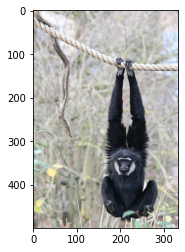

In [101]:
import matplotlib.pyplot as plt
idx = 40001
plt.imshow(dataset[idx][0])
print(dataset._label_map[dataset[idx][1]])